<a href="https://colab.research.google.com/github/indum8/LiDAR-Based-Object-Detection/blob/main/LiDAR_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [28]:
#Connects google drive to colab #Makes drive accessible from colab #when session ends everything will be deleted to avoid we mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#functions to work with files and
#os.makedirs() - create folders
#os.chdir() - change directory
import os

In [30]:
#Creates a variable storing the path to your project folder
#This is where all your project files will be saved

project_path = '/content/drive/MyDrive/KITTI_Project'

In [31]:
#Creates nested folders for organizing KITTI data
#Creates all parent folders automatically
os.makedirs(f'{project_path}/data/training/velodyne', exist_ok=True)
os.makedirs(f'{project_path}/data/training/label_2', exist_ok=True)
os.makedirs(f'{project_path}/data/training/calib', exist_ok=True)


In [32]:
#Changes the current working directory to your project folder
#Like using cd command in terminal
os.chdir(project_path)


In [33]:
print(f"✅ Project folder: {project_path}")

✅ Project folder: /content/drive/MyDrive/KITTI_Project


Install Libraries

In [34]:
#Installs the Open3D library for 3D visualization in -q quiet mode
#A library for working with 3D data
#Used for visualizing point clouds in 3D
#Provides interactive 3D viewers
#Can rotate, zoom, and pan 3D visualizations
!pip install open3d -q

In [35]:
#LiDAR data is stored as arrays of numbers
#Point clouds are NumPy arrays: [[x1, y1, z1], [x2, y2, z2], ...]
import numpy as np

In [36]:
#Create 3D scatter plots of point clouds
#Create bird's eye view (top-down) plots
#Visualize bounding boxes
#Display statistics and analysis
import matplotlib.pyplot as plt

In [37]:
#Axes3D is the 3D plotting engine
from mpl_toolkits.mplot3d import Axes3D

In [38]:
#Better 3D visualization than Matplotlib
import open3d as o3d

In [39]:
#Colab notebooks need this to display plots
%matplotlib inline

In [40]:
print("✅ Libraries loaded!")

✅ Libraries loaded!


Data Loader Class

In [41]:
#This class will handle loading KITTI data files #Class is like a recipe or blueprint for making a data loader
class KITTILoader:
    """
    Loads KITTI dataset files.

    KITTI stores data as:
    - .bin files: LiDAR point clouds (binary)
    - .txt files: Labels and calibration (text)
    """
    #When we create a loader, it remembers where our files are
    # self = "I am the data loader" ✅ self.velodyne_path = "MY path to velodyne files" ✅ self.label_path = "MY path to label files" ✅
    def __init__(self, data_path='data/training'):
        self.velodyne_path = f"{data_path}/velodyne"
        self.label_path = f"{data_path}/label_2"
        self.calib_path = f"{data_path}/calib"
    #"I (self = data loader) have a function to load velodyne data. Tell me which frame_id you want."
    #self = me (the data loader)
    #frame_id = which frame number? (0, 1, 2, 3, etc.)
    def load_velodyne(self, frame_id):
        """
        Load LiDAR point cloud.

        Returns: (N, 4) array with [x, y, z, intensity]
        """
        #self.velodyne_path = MY velodyne folder path = "data/training/velodyne"
        #{frame_id:06d} = format frame_id as 6 digits with leading zeros
        #.bin = file extension
        file_path = f"{self.velodyne_path}/{frame_id:06d}.bin"

        # Read binary file as float32 - "I will read the binary file and convert it to numbers"
        #np.fromfile() = NumPy function to read binary files
        #file_path = the file to read
        #dtype=np.float32 = each number is a 32-bit floating point number
        #points = [2.5, 1.3, 0.8, 0.9, 3.1, 1.5, 0.7, 0.8, ...]
        #          x1   y1   z1   i1   x2   y2   z2   i2



        points = np.fromfile(file_path, dtype=np.float32)

        # Reshape to (N, 4): each row is [x, y, z, intensity]
        #I will organize these numbers into a table with 4 columns"
        #Why reshape?
        #Makes it easy to work with: each row = one point
        #points = [[x,  y,  z,  intensity]
        #x = forward/backward distance (meters)
        #y = left/right distance (meters)
        #z = up/down height (meters)
        #intensity = how bright the laser reflection was (0-1)
        points = points.reshape(-1, 4)

        #"Here are the points I loaded! I'm giving them back to you."
        return points


    #"I (the data loader) will load labels for a specific frame"
    def load_labels(self, frame_id):
        """
        Load object labels (bounding boxes).

        Returns: List of objects with type, location, size
        """
        #"I will find the label file for this frame"
        file_path = f"{self.label_path}/{frame_id:06d}.txt"

        # "I will create an empty basket to collect all the objects I find"
        objects = []

        #open(file_path, 'r') = open the file in read mode
        #'r' = read mode (not writing)
        #as f = call it f (short for "file")
        #with = automatically close the file when done
        with open(file_path, 'r') as f:

            #f.readlines() = get all lines from the file
            #for line in ... = loop through each line
            #Each line represents one object
            for line in f.readlines():

                #Step 1: line.strip()
                #Removes extra spaces and newline at the end
                #Before: "Car 0.00 0 -1.58 ...\n"
                #After: "Car 0.00 0 -1.58 ..."
                #Step 2: .split(' ')
                #Splits the line wherever there's a space
                #Creates a list of strings
                #Eg:
                #line = "Car 0.00 0 -1.58 614.24 181.78 727.31 284.77 1.57 1.73 4.15 1.84 1.47 8.41 -1.56"
                # Result:
                #parts = ['Car', '0.00', '0', '-1.58', '614.24', '181.78', '727.31', '284.77',
                #        '1.57', '1.73', '4.15', '1.84', '1.47', '8.41', '-1.56']
                #        [0]     [1]     [2]   [3]      [4]      [5]      [6]      [7]
                #        [8]     [9]     [10]   [11]     [12]     [13]     [14]

                parts = line.strip().split(' ')

                #KITTI Label Format (Official Standard):
                #Every line in the label file has exactly 15 values in this exact order:

                #Position:  0      1         2        3      4-7              8      9     10      11    12    13      14
                #Value:     type   truncated occluded alpha  bbox_2d(4 vals)  height width length  x     y     z       rotation_y

                obj = {
                    'type': parts[0], #The kind of object (Car, Pedestrian, Cyclist, etc.)
                    'dimensions': [float(parts[8]), float(parts[9]), float(parts[10])], #How big the object is (height, width, length) in meters
                    'location': [float(parts[11]), float(parts[12]), float(parts[13])], #Where the object is in 3D space (x, y, z) in meters
                    'rotation_y': float(parts[14]) #Which direction the object is facing (angle in radians)
                }
                objects.append(obj) #"I will add this object to my collection"

        return objects # "Here's the complete list of all objects I found!"

# Create loader instance
loader = KITTILoader()
print("✅ KITTILoader ready!")

✅ KITTILoader ready!


Point Cloud Processor

In [42]:
#This class filters and cleans the LiDAR data. Removes unwanted points from the point cloud (too far away, ground points, weak signals)
class PointCloudProcessor:
    """Process and filter point clouds."""

    #Removes points that are too far away - Far points are less accurate, often noise, not relevant for nearby obstacle detection
    def filter_by_range(self, points, max_range=50.0):
        """Keep only points within max_range meters."""
        #"Calculate how far each point is from the sensor"
        #It calculates Distance from sensor (origin) to each point in meters
        distances = np.sqrt(np.sum(points[:, :3]**2, axis=1))
        #"Mark which points are close enough"
        mask = distances <= max_range
        #"Keep only the points where mask is True"
        return points[mask]

    #Removes points that are too low (ground/road)
    def remove_ground(self, points, ground_threshold=-1.5):
        """Remove ground points (below threshold height)."""
        #points[:, 2] = all Z coordinates (height)
        #> ground_threshold = higher than threshold
        #ground_threshold = -1.5 = -1.5 meters (below sensor)
        mask = points[:, 2] > ground_threshold
        return points[mask]

    #Removes points with weak laser reflections
    def filter_by_intensity(self, points, min_intensity=0.1):
        """Remove weak LiDAR returns."""
        #points[:, 3] = all intensity values (column 3)
        #>= min_intensity = strong enough
        #min_intensity = 0.1 = minimum acceptable intensity
        mask = points[:, 3] >= min_intensity
        return points[mask]

    # NEW: Normalize intensity values to [0, 1] range
    def normalize_intensity(self, points):
        """
        Normalize intensity values to [0, 1] range for consistent visualization.

        Why normalize?
        - KITTI intensity values can vary widely between frames
        - Normalization ensures consistent grayscale coloring in visualizations
        - Makes it easier to compare different frames
        """
        # Check if there are any non-zero intensities to avoid division by zero
        if np.max(points[:, 3]) > 0:
            # Divide all intensities by the maximum value
            # Example: if max = 255, then 255/255 = 1.0, 128/255 = 0.5, etc.
            points[:, 3] = points[:, 3] / np.max(points[:, 3])
        return points

processor = PointCloudProcessor()
print("✅ Processor ready!")

✅ Processor ready!


Visualizer

In [43]:
#Creates visual plots so you can SEE the point cloud and objects
class Visualizer:
    """Visualize point clouds and bounding boxes."""

    def plot_3d(self, points, title="3D Point Cloud"):
        """3D scatter plot."""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Color by height
        colors = points[:, 2]

        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                           c=colors, cmap='viridis', s=0.1, alpha=0.6)

        ax.set_xlabel('X (forward) [m]')
        ax.set_ylabel('Y (left) [m]')
        ax.set_zlabel('Z (up) [m]')
        ax.set_title(title)
        plt.colorbar(scatter, label='Height [m]')
        plt.show()

    def plot_bev(self, points, objects=None, title="Bird's Eye View"):
        """Top-down view with ROTATED bounding boxes."""
        plt.figure(figsize=(10, 10))

        # Plot points
        plt.scatter(points[:, 0], points[:, 1],
                   s=0.5, c=points[:, 3], cmap='gray', alpha=0.5)

        # Plot bounding boxes with rotation
        if objects:
            for obj in objects:
                loc = obj['location']
                dims = obj['dimensions']
                rot = obj['rotation_y']  # Use the rotation angle from KITTI labels

                # Skip DontCare objects (they have invalid coordinates like -1000)
                if obj['type'] == 'DontCare':
                    continue

                # NEW: Create rotated bounding box
                # Calculate corner points of the box
                l, w = dims[2], dims[1]  # length (x-direction) and width (y-direction)
                x, y = loc[0], loc[1]    # center position

                # Define 5 corners in object's local coordinate system
                # We need 5 points (not 4) to close the rectangle when plotting
                # Starting from bottom-left, going counter-clockwise
                corners = np.array([
                    [-l/2, -w/2],  # Bottom-left
                    [l/2, -w/2],   # Bottom-right
                    [l/2, w/2],    # Top-right
                    [-l/2, w/2],   # Top-left
                    [-l/2, -w/2]   # Back to bottom-left to close the shape
                ])

                # Create 2D rotation matrix
                # This rotates points by angle 'rot' (rotation_y from KITTI)
                # [ cos(θ)  -sin(θ) ]
                # [ sin(θ)   cos(θ) ]
                R = np.array([
                    [np.cos(rot), -np.sin(rot)],
                    [np.sin(rot), np.cos(rot)]
                ])

                # Apply rotation and translation:
                # 1. corners @ R.T - rotate each corner point
                # 2. + np.array([x, y]) - move to object's position
                rotated_corners = corners @ R.T + np.array([x, y])

                # Draw the rotated rectangle
                plt.plot(rotated_corners[:, 0], rotated_corners[:, 1],
                        'r-', linewidth=2, label=obj['type'] if 'label' not in locals() else "")

                # Add label with white background for better readability
                plt.text(x, y, obj['type'],
                        color='red', fontsize=8,
                        ha='center', va='center',  # Center alignment
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.xlabel('X (forward) [m]')
        plt.ylabel('Y (left) [m]')
        plt.title(title)
        plt.axis('equal')  # Equal aspect ratio ensures boxes look correct
        plt.grid(True)
        plt.show()

visualizer = Visualizer()
print("✅ Visualizer ready!")

✅ Visualizer ready!


Main Processing Pipeline

In [44]:
def process_frame(frame_id=0):
    """
    Complete pipeline: Load → Normalize → Process → Visualize
    """
    print(f"\n{'='*60}")
    print(f"Processing Frame {frame_id}")
    print(f"{'='*60}\n")

    # 1. Load data
    print("📂 Loading data...")
    points = loader.load_velodyne(frame_id)
    objects = loader.load_labels(frame_id)
    print(f"   Loaded {len(points):,} points")
    print(f"   Loaded {len(objects)} objects")

    # 2. Process point cloud
    print("\n🔧 Processing point cloud...")

    # NEW: Normalize intensity first (before filtering)
    # This ensures consistent visualization across all frames
    points = processor.normalize_intensity(points)
    print(f"   ✨ Intensity normalized to [0, 1]")

    points = processor.filter_by_range(points, max_range=50.0)
    print(f"   After range filter: {len(points):,} points")

    points = processor.remove_ground(points)
    print(f"   After ground removal: {len(points):,} points")

    # 3. Show detected objects (with rotation info)
    print(f"\n📦 Detected Objects:")
    for i, obj in enumerate(objects, 1):
        # Skip DontCare objects in the printout
        if obj['type'] != 'DontCare':
            print(f"   {i}. {obj['type']}: "
                  f"location={[f'{x:.2f}' for x in obj['location']]}, "
                  f"size={[f'{x:.2f}' for x in obj['dimensions']]}, "
                  f"rotation={obj['rotation_y']:.2f} rad ({np.degrees(obj['rotation_y']):.1f}°)")

    # 4. Visualize (now with rotated bounding boxes!)
    print("\n📊 Creating visualizations...")
    visualizer.plot_3d(points, f"Frame {frame_id} - 3D View")
    visualizer.plot_bev(points, objects, f"Frame {frame_id} - Bird's Eye View (Rotated)")

    return points, objects

print("✅ Pipeline ready!")

✅ Pipeline ready!


Run the Pipeline!


Processing Frame 0

📂 Loading data...
   Loaded 115,384 points
   Loaded 1 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 114,853 points
   After ground removal: 66,890 points

📦 Detected Objects:
   1. Pedestrian: location=['1.84', '1.47', '8.41'], size=['1.89', '0.48', '1.20'], rotation=0.01 rad (0.6°)

📊 Creating visualizations...


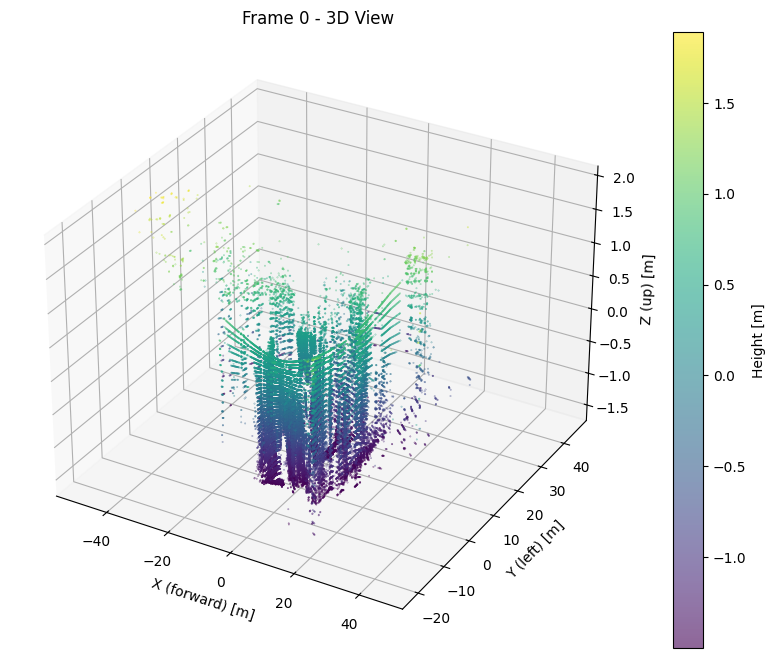

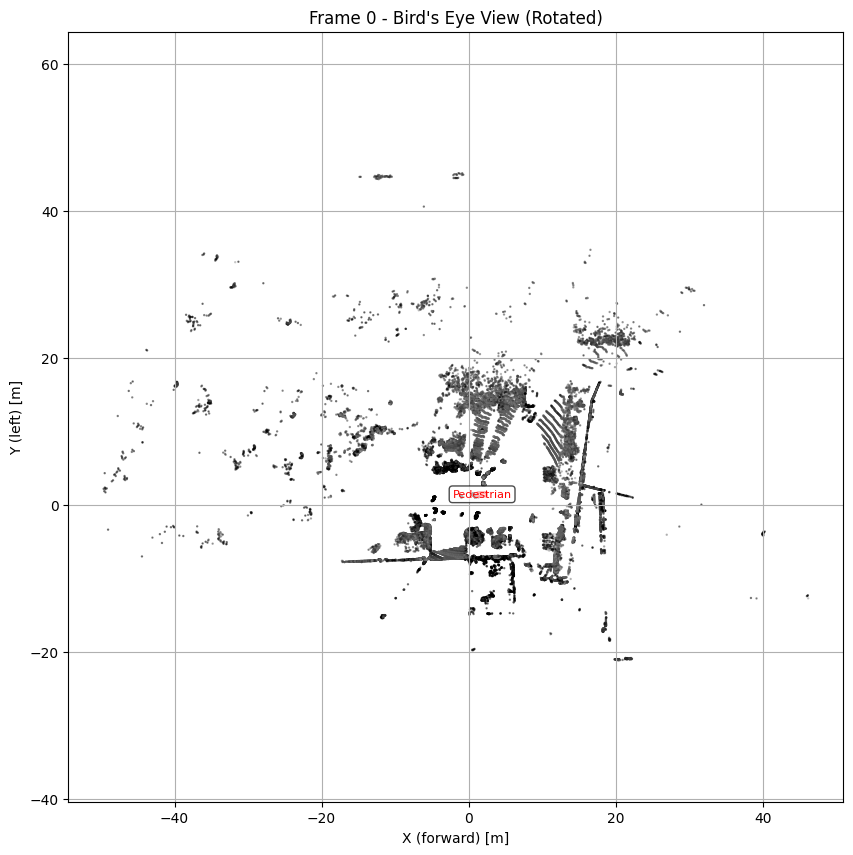

In [45]:
# Process frame 0
points, objects = process_frame(frame_id=0)

In [46]:
display(objects)

[{'type': 'Pedestrian',
  'dimensions': [1.89, 0.48, 1.2],
  'location': [1.84, 1.47, 8.41],
  'rotation_y': 0.01}]

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Process Multiple Frames


Processing Frame 0

📂 Loading data...
   Loaded 115,384 points
   Loaded 1 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 114,853 points
   After ground removal: 66,890 points

📦 Detected Objects:
   1. Pedestrian: location=['1.84', '1.47', '8.41'], size=['1.89', '0.48', '1.20'], rotation=0.01 rad (0.6°)

📊 Creating visualizations...


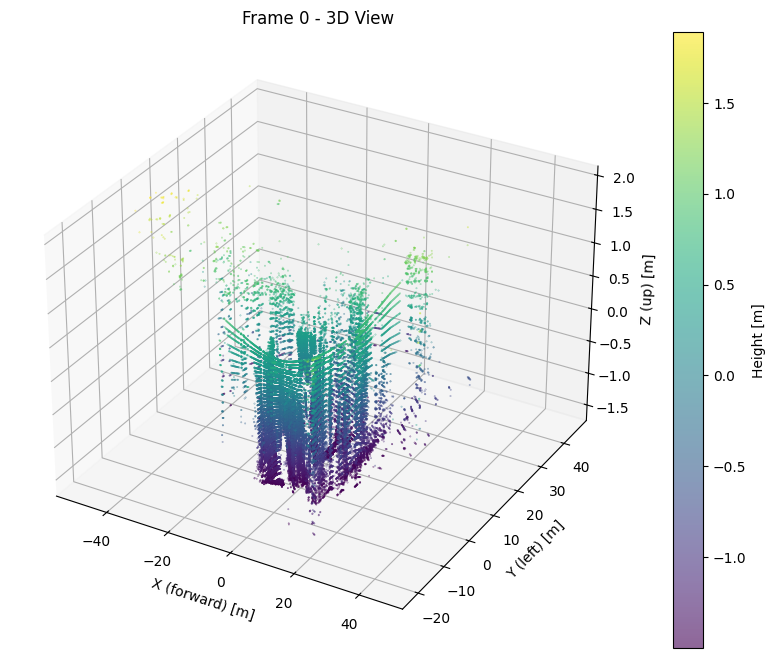

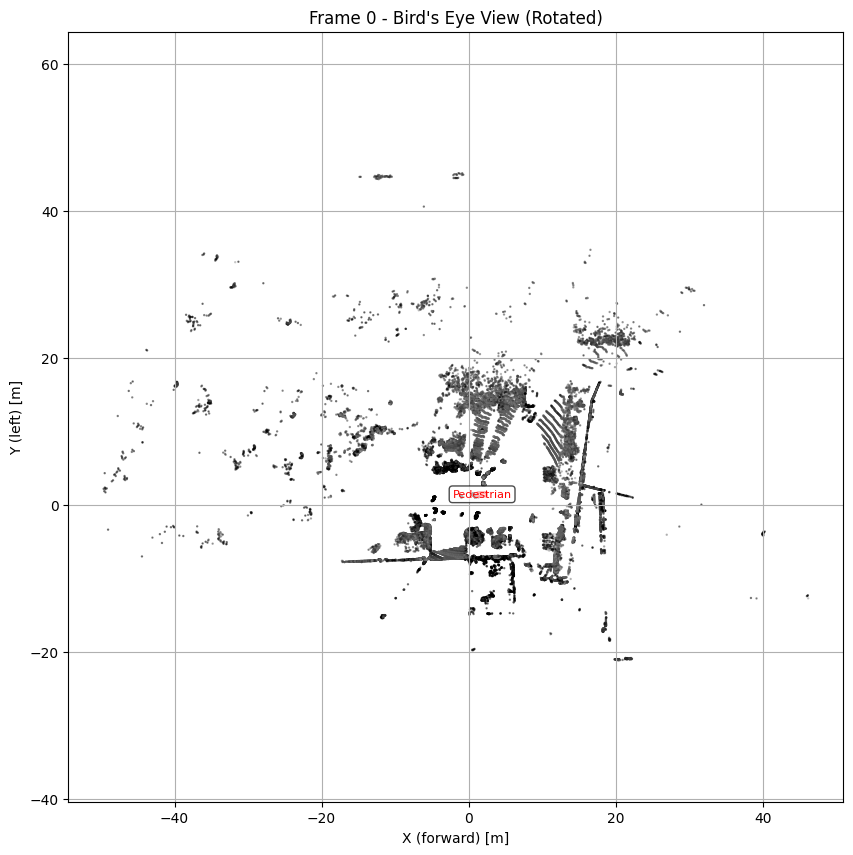


Processing Frame 1

📂 Loading data...
   Loaded 120,268 points
   Loaded 7 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 118,595 points
   After ground removal: 44,838 points

📦 Detected Objects:
   1. Truck: location=['0.47', '1.49', '69.44'], size=['2.85', '2.63', '12.34'], rotation=-1.56 rad (-89.4°)
   2. Car: location=['-16.53', '2.39', '58.49'], size=['1.67', '1.87', '3.69'], rotation=1.57 rad (90.0°)
   3. Cyclist: location=['4.59', '1.32', '45.84'], size=['1.86', '0.60', '2.02'], rotation=-1.55 rad (-88.8°)

📊 Creating visualizations...


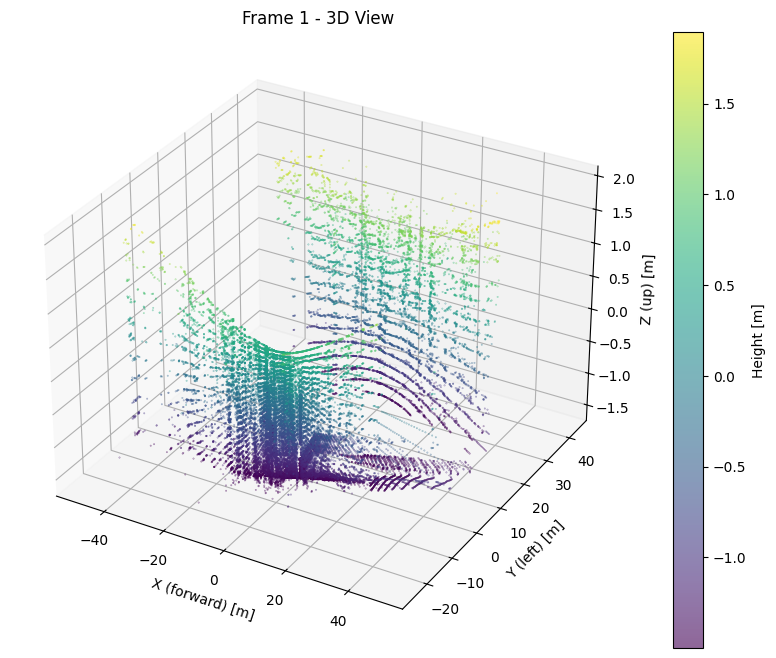

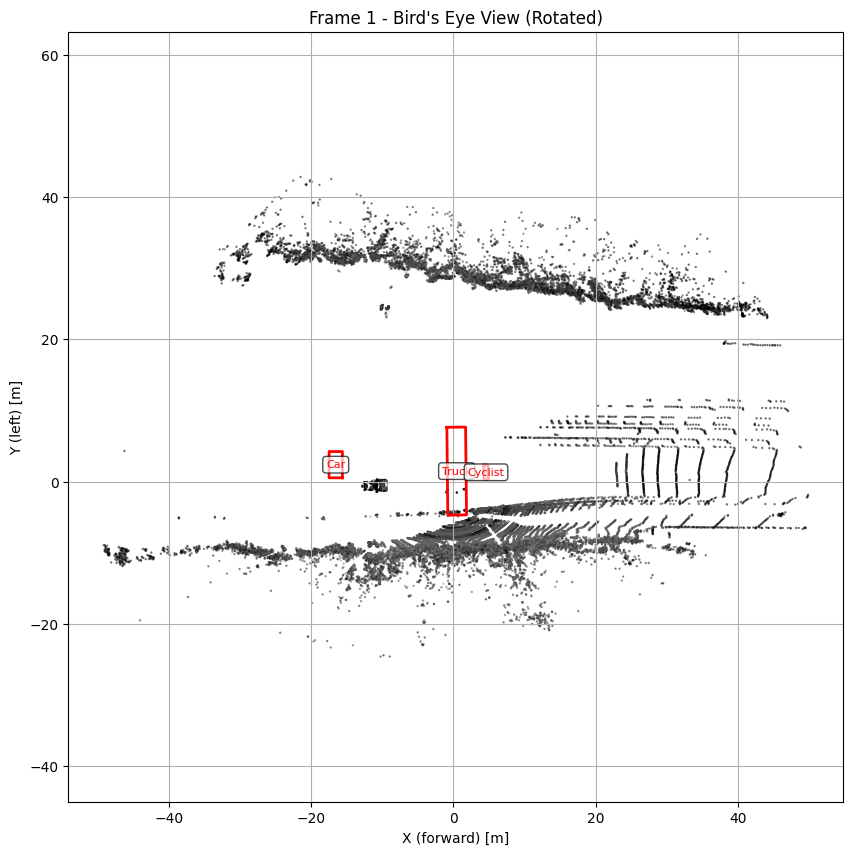


Processing Frame 2

📂 Loading data...
   Loaded 126,891 points
   Loaded 2 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 125,767 points
   After ground removal: 82,778 points

📦 Detected Objects:
   1. Misc: location=['3.23', '1.59', '8.55'], size=['1.63', '1.48', '2.37'], rotation=-1.47 rad (-84.2°)
   2. Car: location=['3.18', '2.27', '34.38'], size=['1.41', '1.58', '4.36'], rotation=-1.58 rad (-90.5°)

📊 Creating visualizations...


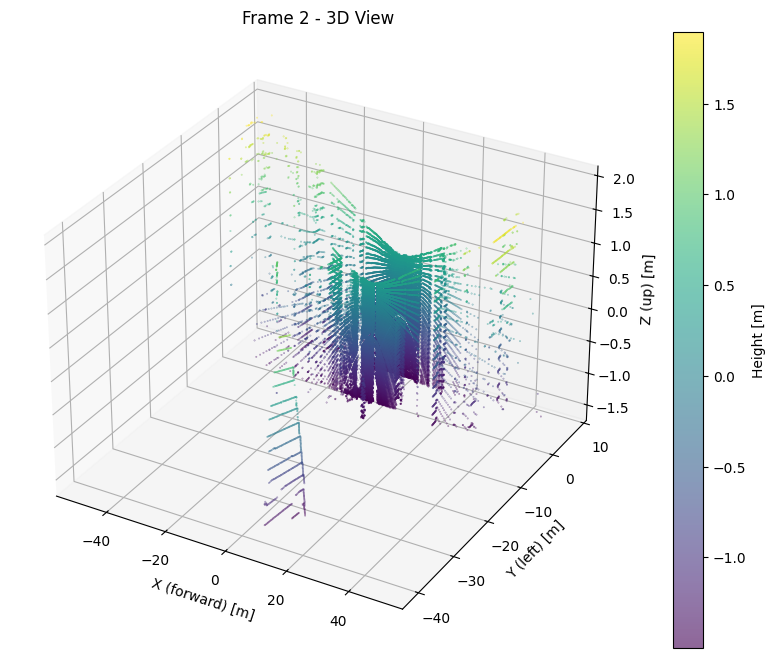

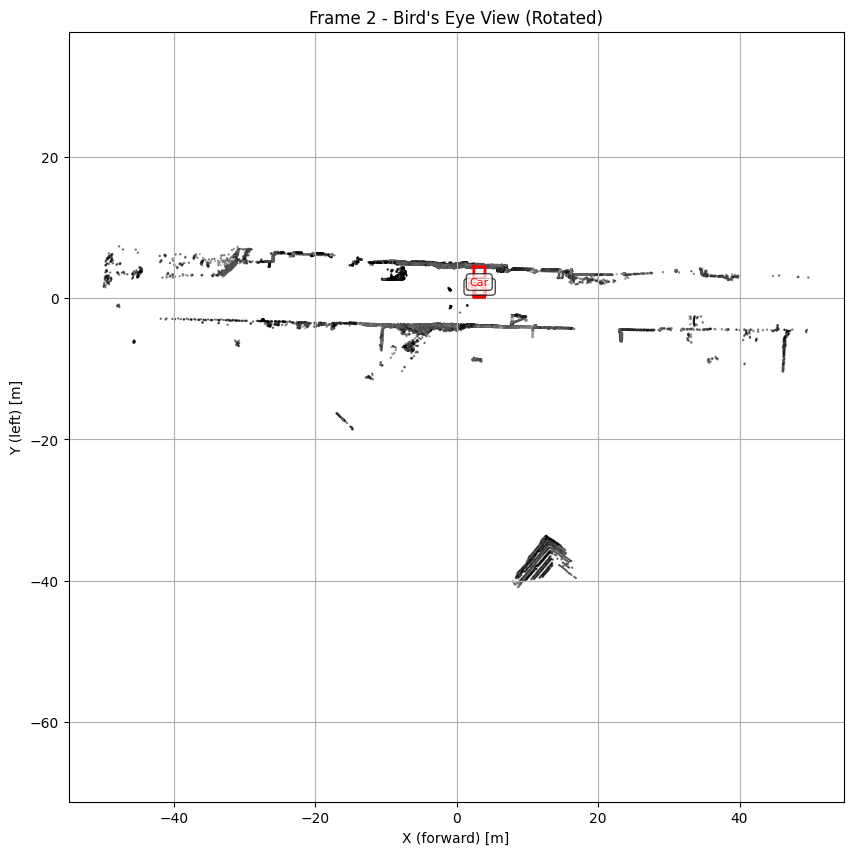


Processing Frame 3

📂 Loading data...
   Loaded 113,110 points
   Loaded 3 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 111,546 points
   After ground removal: 71,159 points

📦 Detected Objects:
   1. Car: location=['1.00', '1.75', '13.22'], size=['1.57', '1.73', '4.15'], rotation=1.62 rad (92.8°)

📊 Creating visualizations...


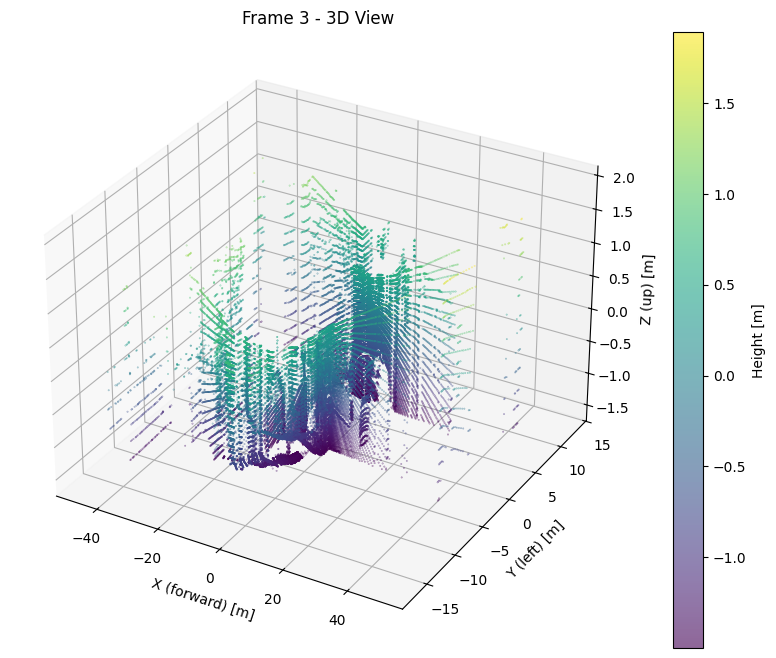

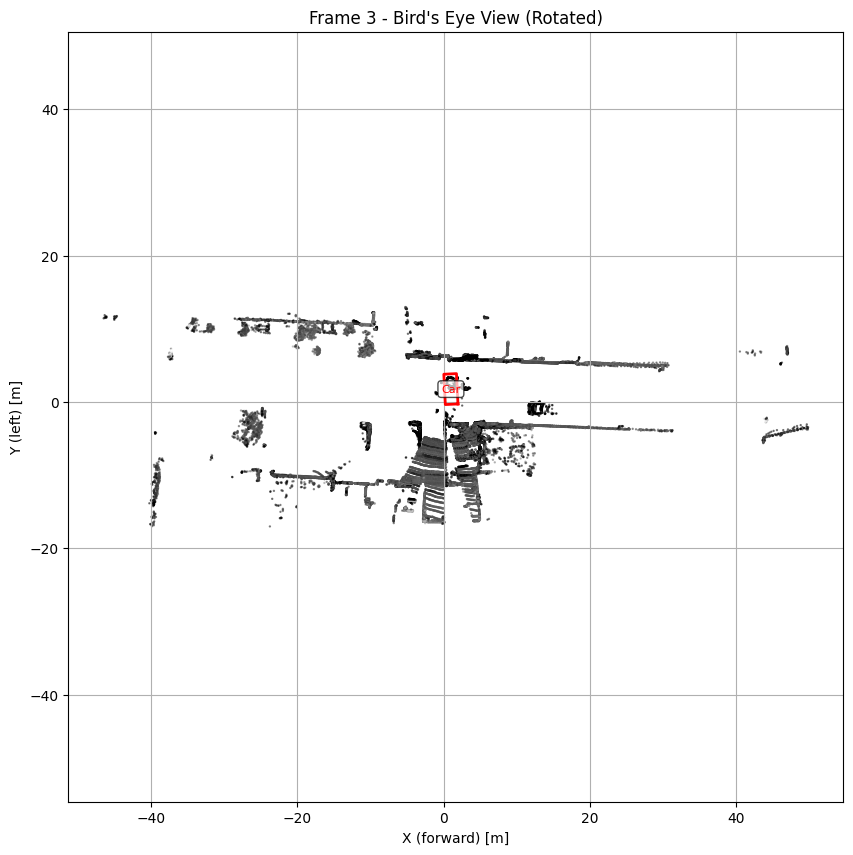


Processing Frame 4

📂 Loading data...
   Loaded 115,976 points
   Loaded 7 objects

🔧 Processing point cloud...
   ✨ Intensity normalized to [0, 1]
   After range filter: 113,896 points
   After ground removal: 40,504 points

📦 Detected Objects:
   1. Car: location=['-15.71', '2.16', '38.26'], size=['1.49', '1.76', '4.01'], rotation=1.57 rad (90.0°)
   2. Car: location=['-15.89', '2.23', '51.17'], size=['1.38', '1.80', '3.41'], rotation=1.58 rad (90.5°)

📊 Creating visualizations...


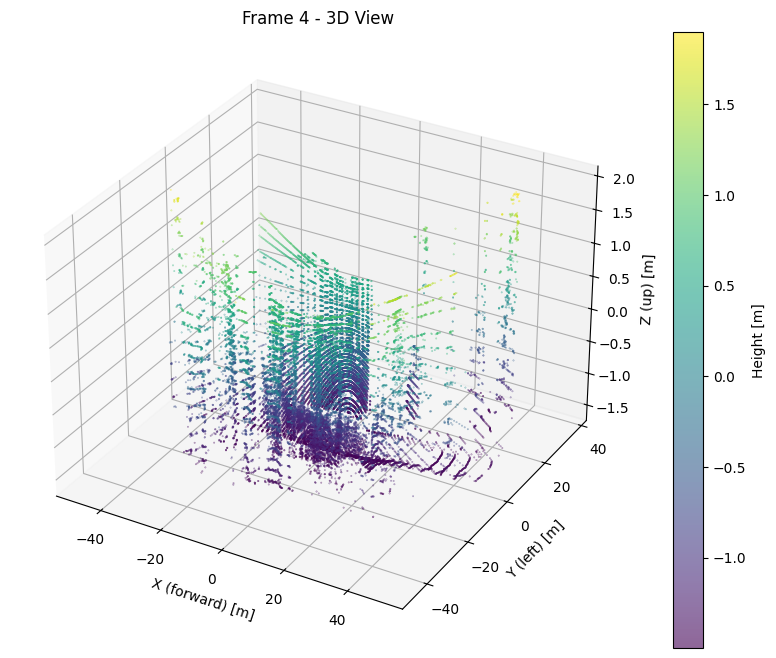

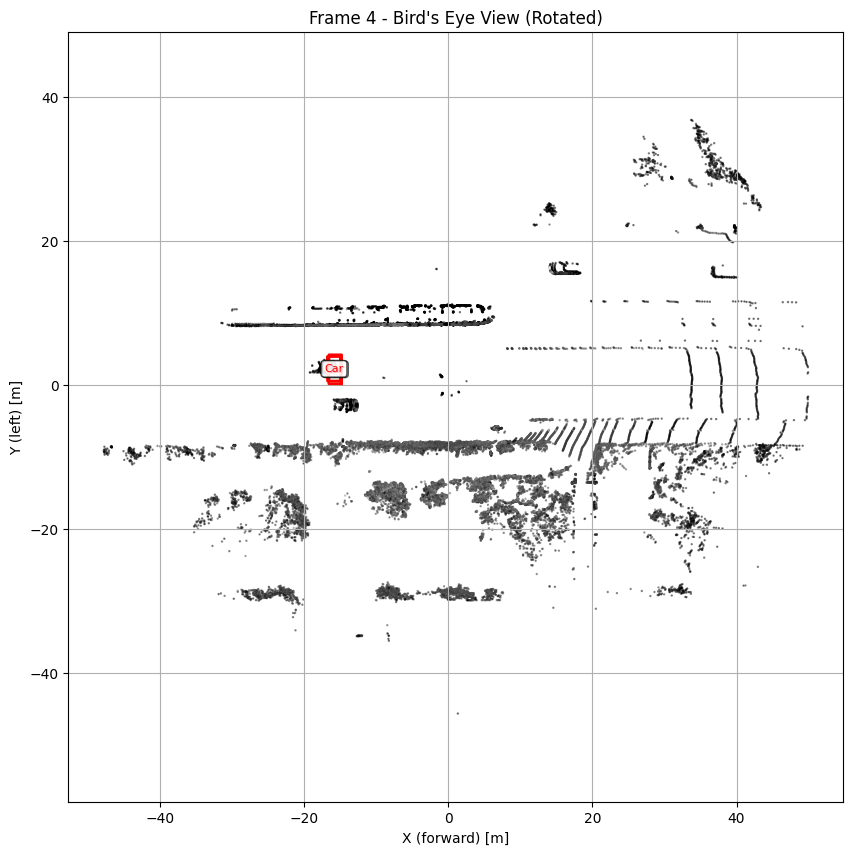

In [48]:
# Process frames 0 to 4
for frame_id in range(5):
    try:
        process_frame(frame_id)
    except FileNotFoundError:
        print(f"⚠️ Frame {frame_id} not found, skipping...")

In [49]:
import json

# Define a path in your Google Drive where you want to save the file
output_file_path = f'{project_path}/detected_objects_frame_0.json'

# Save the objects list to a JSON file
with open(output_file_path, 'w') as f:
    json.dump(objects, f, indent=4)

print(f"✅ Objects saved to: {output_file_path}")

✅ Objects saved to: /content/drive/MyDrive/KITTI_Project/detected_objects_frame_0.json


Statistics and Analysis

In [50]:
def analyze_dataset(num_frames=10):
    """Analyze multiple frames."""
    stats = {
        'total_points': [],
        'total_objects': [],
        'object_types': {}
    }

    for frame_id in range(num_frames):
        try:
            points = loader.load_velodyne(frame_id)
            objects = loader.load_labels(frame_id)

            stats['total_points'].append(len(points))
            stats['total_objects'].append(len(objects))

            for obj in objects:
                obj_type = obj['type']
                stats['object_types'][obj_type] = stats['object_types'].get(obj_type, 0) + 1

        except FileNotFoundError:
            break

    # Print statistics
    print(f"\n{'='*60}")
    print("Dataset Statistics")
    print(f"{'='*60}")
    print(f"Frames analyzed: {len(stats['total_points'])}")
    print(f"Avg points per frame: {np.mean(stats['total_points']):,.0f}")
    print(f"Avg objects per frame: {np.mean(stats['total_objects']):.1f}")
    print(f"\nObject type distribution:")
    for obj_type, count in sorted(stats['object_types'].items()):
        print(f"  {obj_type}: {count}")

    return stats

# Run analysis
stats = analyze_dataset(num_frames=10)


Dataset Statistics
Frames analyzed: 10
Avg points per frame: 119,608
Avg objects per frame: 5.2

Object type distribution:
  Car: 21
  Cyclist: 2
  DontCare: 25
  Misc: 1
  Pedestrian: 2
  Truck: 1
